# 3D Convonlutional Neural Network

#### Install dependencies

In [23]:
%pip install tensorflow[and-cuda] keras gdown

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


#### Prepare imports

In [24]:
import tensorflow # This is the ML library we will use
from tensorflow.keras.models import Sequential # This is the Sequential layer that runs all the sublayers inside
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D # These are the layer we will use in the model
from tensorflow.keras.utils import to_categorical # This is used to transform labels to categorical format
import h5py # This is used to work with h5 files
import numpy as np # This is used to handle arrays of data
import matplotlib.pyplot as plt # This is to load plotting functions
import gdown # This is used to download data from Google Drive
import os # This is used to work with file system

#### Prepare paths of the data and models

In [26]:
ROOT = "./data"
PRETRAINED_MODEL_PATH = ROOT + '/pretrained_3d_cnn.h5'
MODEL_PATH = ROOT + '/3d_cnn.keras'
DATSET_PATH = ROOT + '/full_dataset_vectors.h5'

os.makedirs(ROOT, exist_ok=True)

#### Download the 3D MNIST dataset and the pretrained model files

In [27]:
gdown.download(
    'https://drive.google.com/uc?id=1-jDaDuk5ePsRtS1TU85zJ2euBUPc05mU',
    DATSET_PATH,
    quiet=False
)
gdown.download(
    'https://drive.google.com/uc?id=1EG5g_xYCH7gtV6Zdrt1F_h6AQRQHzyGd',
    PRETRAINED_MODEL_PATH,
    quiet=False
)

Downloading...
From: https://drive.google.com/uc?id=1-jDaDuk5ePsRtS1TU85zJ2euBUPc05mU
To: /mnt/d/FILES/Code/Teaching/diiP2024_SL_Solutions/data/full_dataset_vectors.h5
100%|██████████| 30.6M/30.6M [00:01<00:00, 19.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EG5g_xYCH7gtV6Zdrt1F_h6AQRQHzyGd
To: /mnt/d/FILES/Code/Teaching/diiP2024_SL_Solutions/data/pretrained_3d_cnn.h5
100%|██████████| 2.35M/2.35M [00:00<00:00, 6.72MB/s]


'./data/pretrained_3d_cnn.h5'

#### Model configuration

In [28]:
batch_size = 100 # Number of images to process at once 
no_epochs = 30 # Number of epochs to train the model
learning_rate = 0.001 # Rate of change of model parameters each training step
no_classes = 10 # Number of classes in the dataset
validation_split = 0.2 # Fraction of data to be used for validation 
verbosity = 1 # How verbose the training should be

#### Helper functions

In [29]:
# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
  return np.asarray(data_t, dtype=np.float32)

#### Load the dataset from the downloaded data file

In [30]:
# Load the HDF5 data file
with h5py.File(DATSET_PATH, "r") as hf:

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:]
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.int64)
    targets_test = to_categorical(targets_test).astype(np.int64)

#### Create the model

Use model.add function to add the following layers:

Conv3D layer with 32 output channels, kernel size of 3x3x3, relu activation function, he_uniform function for kernel initializer, input_shape=sample_shape

MaxPooling3D layer with 2x2x2 size

Conv3D layer with 64 output channels, kernel size of 3x3x3, relu activation function, he_uniform function for kernel initializer

MaxPooling3D layer with 2x2x2 size

Flatten layer

Dense layer with 256 output dimensions, relu activation function, he_uniform function for kernel initializer

Dense layer with `no_classes` output dimensions and softmax activation function

<details>
<summary>Solution</summary>
    <code>
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))<br>
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))<br>
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))<br>
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))<br>
    model.add(Flatten())<br>
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))<br>
    model.add(Dense(no_classes, activation='softmax'))<br>
    </code>
</details>

In [39]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 14, 14, 14, 32)    2624      
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 7, 7, 7, 32)       0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 5, 5, 64)       55360     
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 2, 2, 2, 64)       0         
 g3D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

#### Train the model

In [32]:
# Compile the model
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# Fit model to data 
history = model.fit(X_train, targets_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)
model.save(MODEL_PATH)

Epoch 1/30
80/80 [==============================] - 3s 27ms/step - loss: 2.2592 - accuracy: 0.1974 - val_loss: 1.9361 - val_accuracy: 0.3270
Epoch 2/30
80/80 [==============================] - 2s 28ms/step - loss: 1.7878 - accuracy: 0.3913 - val_loss: 1.6217 - val_accuracy: 0.4500
Epoch 3/30
80/80 [==============================] - 2s 25ms/step - loss: 1.5031 - accuracy: 0.4911 - val_loss: 1.5010 - val_accuracy: 0.5015
Epoch 4/30
80/80 [==============================] - 2s 25ms/step - loss: 1.3794 - accuracy: 0.5253 - val_loss: 1.4099 - val_accuracy: 0.5120
Epoch 5/30
80/80 [==============================] - 2s 24ms/step - loss: 1.2893 - accuracy: 0.5574 - val_loss: 1.3205 - val_accuracy: 0.5565
Epoch 6/30
80/80 [==============================] - 2s 24ms/step - loss: 1.1996 - accuracy: 0.5882 - val_loss: 1.2489 - val_accuracy: 0.5760
Epoch 7/30
80/80 [==============================] - 2s 24ms/step - loss: 1.1510 - accuracy: 0.6039 - val_loss: 1.2411 - val_accuracy: 0.5765
Epoch 8/30
80

#### Load the pretrained model weights into a separate model

In [36]:
pretrained_model = tensorflow.keras.models.load_model(PRETRAINED_MODEL_PATH)
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 14, 14, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 7, 7, 32)       0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 5, 64)       55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 2, 2, 64)       0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               1

#### Test the models

In [37]:
# Generate generalization metrics
score_pretrained = pretrained_model.evaluate(X_test, targets_test, verbose=0)
score = model.evaluate(X_test, targets_test, verbose=0)
print(f'Pretrained model. Test loss: {score_pretrained[0]} / Test accuracy: {score_pretrained[1]}')
print(f'Trained model. Test loss: {score[0]} / Test accuracy: {score[1]}')

Pretrained model. Test loss: 1.7864867448806763 / Test accuracy: 0.6679999828338623
Trained model. Test loss: 1.2103594541549683 / Test accuracy: 0.6620000004768372


#### Plot losses

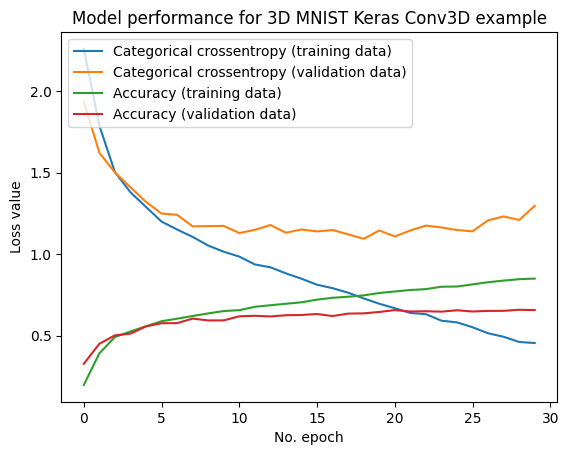

In [38]:

# Plot history: Categorical crossentropy & Accuracy
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()